# Lab Image Processing Class
## Image Classification with Keras/Tensorflow

In [1]:
# Imports

# Library allowing downloads of google images
from google_images_download import google_images_download

# Miscellaneous operating system libraries
import os
import shutil
import numpy as np
import random

# Libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from IPython.display import display, Image

# Deep learning libraries Keras and Tensorflow for training and sklearn for the metrics
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf

## Download images from Google

Below, we will download images from Google based on the search queries we give. You can also use your own images, if you do, I recommend to have the following data structure:

- Lab_image_processing (the Github repository)
    - Image_classification.ipynb
    - ...
- Data
    - Train 
        - Class 1
        - Class 2
    - Val
        - Class 1
        - Class 2
    - Inf
        - Class 1
        - Class 2
- Models

If you want to download images from google, you can use the function below, it will also create the right folder structure.

In [6]:
# Function to download Google images
# Again, you are welcome to use your own data

def download_images(home_folder, dict_data, classes):
    
    # get response from google
    response = google_images_download.googleimagesdownload()

    # get number of total images to download
    n_images = sum([dict_data[label] for label in dict_data])
    for label in classes:
        
        # creating dictionary of arguments for downloading from google
        # all possible arguments you can find here: 
        # https://google-images-download.readthedocs.io/en/latest/arguments.html
        arguments = {
                    "keywords":label,"limit":n_images,"print_urls":False,
                    "size":"large",
                    "output_directory":home_folder
                    }   
        # passing the arguments to the function
        paths = response.download(arguments)   
        
        # create folder structure
        for one_part in dict_data:
            img_per_set = dict_data[one_part]
            output_folder = home_folder + one_part + '/' + label
            
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)
                
            all_files = os.listdir(home_folder + label)
            
            # go through all downloaded files and split up the data
            # for example: total images 100
            # train:70, val:20, inf: 10
            for index, file in enumerate(all_files):
                if index < img_per_set:
                    
                    # change file name if it ends with the file extension .webp
                    if file.endswith('webp'):
                        file2 = file[:-5]
                        
                        # move files to the designated folders
                        shutil.move(
                            home_folder + label + '/' + file,
                            output_folder + '/' + file2
                                    )
                    else:
                        # move files to the designated folders
                        shutil.move(
                        home_folder + label + '/' + file,
                        output_folder + '/' + file
                                    )
                # update the list of files
                all_files = os.listdir(home_folder + label)




In [7]:
# define our home folder
HOME = '../Data/'
# create dictionary based on how many images we wany per set
dict_folders = {'Train':30, 'Val':10, 'Inf':5}
# define the classes
classes = ['beach', 'forest']
# pass the arguments and download the images
download_images(HOME, dict_folders, classes)


Item no.: 1 --> Item name = beach
Evaluating...
Starting Download...
Completed Image ====> 1.grass-in-beach-sand.jpg
Completed Image ====> 2.181010131059-australia-best-beaches-cossies-beach-cocos3.jpg
Completed Image ====> 3.havsbad.%20bettnesand_0.jpg
Completed Image ====> 4.aerial-one&onlyreethirah-maldives-crhotel.jpg
Completed Image ====> 5.beach-quotes-1559667853.jpg
URLError on an image...trying next one... Error: HTTP Error 403: Forbidden
Completed Image ====> 6.beach-5b59c9b7c9e77c004b3e0ff0.jpg
Completed Image ====> 7.7milebeach-2013-hires.jpg
Completed Image ====> 8.1200x1200-affischer-posters_2019-12_med-kant_black_beach1.jpg
Completed Image ====> 9.bondi-beach-sydney.jpg.webp
Completed Image ====> 10.saud_beach_g.jpg
Completed Image ====> 11.experiences_beach.jpg
Completed Image ====> 12.merlin_172213740_1af4eb26-f691-4b4d-b145-848a933e7ad2-mobilemasterat3x.jpg
Completed Image ====> 13.sunset-beach_background.jpg
Completed Image ====> 14.homepage-01.jpeg
Completed Image =

## Data preparation

In [25]:
# function to prepare the data and save the data in memory as numpy arrays
# Important: here we are also going to resize the data, as for most networks,
# all data points have to be the same shape.

def get_data(data_dir, classes, img_size):
    data = [] 
    for label in classes: 
        path = os.path.join(data_dir, label)
        class_num = classes.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)


In [26]:
# Define the target image size, the larger, the more features, but also longer training times.
# If you have a decent laptop, 256 pixels is fine.
img_size = 256

train = get_data(HOME + 'Train/', classes, img_size)
val = get_data(HOME + 'Val/', classes, img_size)

<AxesSubplot:ylabel='count'>

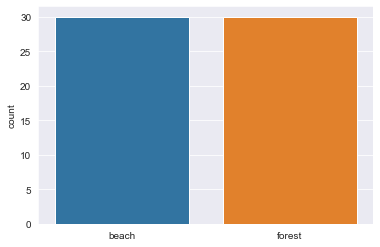

In [27]:
# view the data and review how many of the training images are availabe
# useful to verify that we loaded all the images from the training data set as numpy arrays
# sometimes, with faulty file endings, there might be errors
l = []
for i in train:
    if(i[1] == 0):
        l.append(classes[0])
    else:
        l.append(classes[1])
sns.set_style('darkgrid')
sns.countplot(x=l)


Text(0.5, 1.0, 'beach')

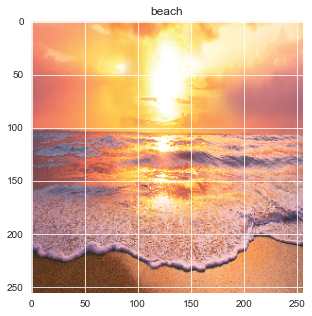

In [28]:
# show one image from the first class
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(classes[train[0][1]])

Text(0.5, 1.0, 'forest')

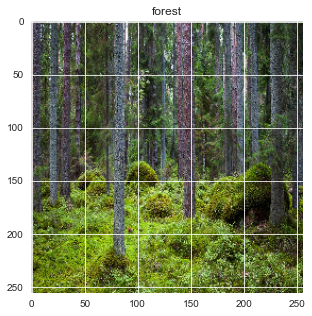

In [29]:
# show one image from the second class
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(classes[train[-1][1]])

In [30]:
# Data preprocessing

x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [39]:
# data augmentation on training data
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## Model Definition

In [40]:
# Define the model 
# This is a simple CNN model with 3 Convolutional layers that are then followed by max-pooling layer.
# Finally, a dropout layer is added to avoid overfitting (it might still happen).

model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(img_size,img_size,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

# A summary of the model is going to be printed below

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 64)       

## Training

Now we define what kind of optimizer we use for the training process. There are many different optimizers that you could choose from and you can find them here (https://keras.io/api/optimizers/). For now, I will choose the Adam optimizer. It is a stochastic gradient descent method based on adaptive estimation of first-order and second-order moments (From https://keras.io/api/optimizers/adam/).

We will also have to set the learning rate (float from 0.0 - 1.0) for our stochastic gradient descent. The learning rate can be defined as the amount that the weights are updated during training per epoch. It controls how quickly the model tries to adapt to the problem. With larger learning rates the model might learn too quickly and unstable, while with smaller learning rates the model needs more epochs to finish training successfully (more info here https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/).

Apart from the size of the data set, the learning rate and the number of epochs might be the two most important parameters for using deep learning algorithms.

In [41]:
# Set learning rate and epochs
lr_training = 0.0001
epochs = 50

# Set the optimizer and compile model
opt = Adam(lr_training)

# set the loss calculation, here it is Sparse Categorical Crossentropy 
# (https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)
model.compile(
    optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics = ['accuracy']
            )

In [42]:
# start the training
# this step might take a while depending on the size of the data set, the number of epochs and your computational power.
history = model.fit(x_train,y_train,epochs = epochs , validation_data = (x_val, y_val))

Epoch 1/50
2/2 [==============================] - 6s 3s/step - loss: 0.7785 - accuracy: 0.4347 - val_loss: 0.6775 - val_accuracy: 0.5000
Epoch 2/50
2/2 [==============================] - 8s 3s/step - loss: 0.6614 - accuracy: 0.4479 - val_loss: 0.5931 - val_accuracy: 0.5500
Epoch 3/50
2/2 [==============================] - 8s 4s/step - loss: 0.5434 - accuracy: 0.6549 - val_loss: 0.4959 - val_accuracy: 0.8500
Epoch 4/50
2/2 [==============================] - 7s 3s/step - loss: 0.4313 - accuracy: 0.9785 - val_loss: 0.4275 - val_accuracy: 0.9000
Epoch 5/50
2/2 [==============================] - 7s 4s/step - loss: 0.3462 - accuracy: 0.9674 - val_loss: 0.3775 - val_accuracy: 0.8500
Epoch 6/50
2/2 [==============================] - 9s 4s/step - loss: 0.2803 - accuracy: 0.9229 - val_loss: 0.3549 - val_accuracy: 0.8500
Epoch 7/50
2/2 [==============================] - 9s 4s/step - loss: 0.2348 - accuracy: 0.8924 - val_loss: 0.2924 - val_accuracy: 0.8500
Epoch 8/50
2/2 [=========================

### Explanation of training metrices

- Loss: Measures the difference between raw prediction (float) and class (0, 1)
- Accuracy: Measures the difference between thresholded prediction (0, 1) and class (0, 1)

Here, we differentiate between train loss/accuracy and val loss/accuracy. Both are calculated very similarly, but only the train loss/accuracy is taken into account when training the model, while the val loss/accuracy is only there for us to observe and is not participating in changing any weights in the model.

Below we plot the accuracy and the loss.

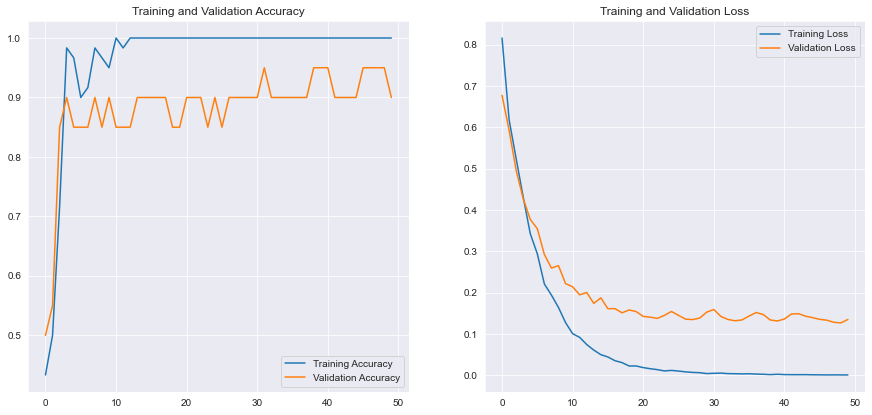

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs as variable
epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

If you want to review good/bad learning curves with over/underfitting, you can do this here (https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/).

Sometimes, it is not perfectly clear, whether under/overfitting is actually really bad for the problem we want to solve. Intuitively, we would think, that the validation loss and the validation accuracy are inversely correlated, but sometimes this is not the case. In a case where images with borderline predictions are getting predicted better and their output class changes (beach image is being predicted from 0.4 to 0.6) the loss decreases, while the accuracy increases. However, in a case where an image with a very bad prediction changes from 0.2 to 0.1 (the prediction is a beach but it is actually a forest), the loss decreases further, while the accuracy actually stays the same.

In a perfect world, the loss will decrease and the accuracy increase. If both increase, we can say that the network will start to overfit and both cases will happen at the same time. This means that features are learned that are good for the training data set and not so great for generalization/the validation data set. This will then lead to case 2. However, at the same time the network is still learning useful patterns leading to case 1. 

Long story short, overfitting may be considered bad, but whether we should stop training if the network learns bad patterns even though it is continuing to learn good patterns is difficult to answer.

If you observe, that your loss/accuracy curves look really bad, consider changing your dataset size, epochs or learning rate.

Below, we will also calculate the F1-score, more info is to be found here (https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234).

In [69]:
# Get F1-score
predictions = np.argmax(model.predict(x_val), axis=-1)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = [classes[0] + ' (Class 0)',classes[1] + ' (Class 1)']))

                  precision    recall  f1-score   support

 beach (Class 0)       1.00      0.80      0.89        10
forest (Class 1)       0.83      1.00      0.91        10

        accuracy                           0.90        20
       macro avg       0.92      0.90      0.90        20
    weighted avg       0.92      0.90      0.90        20



# Inference

Next, the previously trained model makes a prediction based on what it has learned from the data on new, unseen inference data.

In [72]:
import random
from IPython.display import display, Image
# define path
inf_path = HOME + 'Inf/'

# get list of all inference files available
inference_files = [os.path.join(root, name)
                  for root, dirs, files in os.walk(inf_path)
                  for name in files]

../Data/Inf/beach/24.es-trenc-beach-mallorca-1.jpg
This image is 100.0 percent beach and 0.0 percent forest.


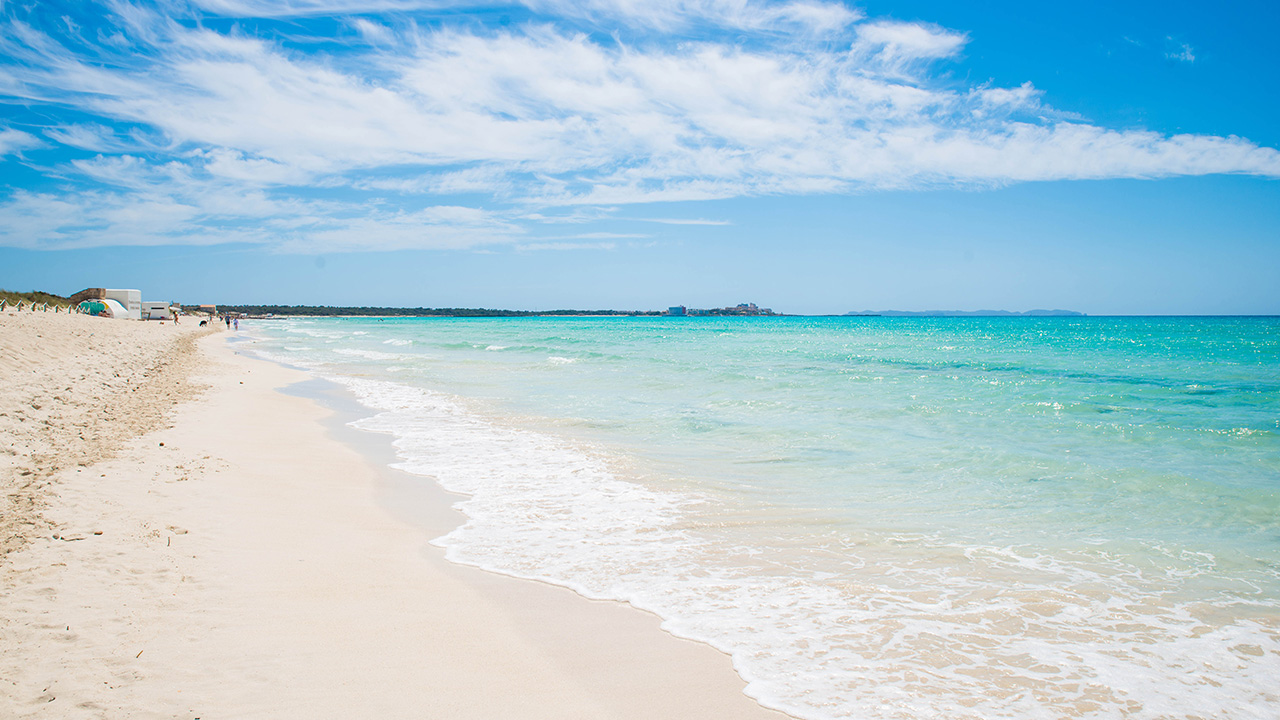

In [73]:
# select random image
rdm_img = random.choice(inference_files)
image_size = (img_size,img_size)

# predict on random image
img = keras.preprocessing.image.load_img(
    rdm_img, target_size=image_size
    )
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)

# get score for prediciton
score = predictions[0]

# print results
print(rdm_img)
print(
    'This image is %.1f percent %s and %.1f percent %s.'
    %(score[0] * 100, classes[0], score[1] * 100, classes[1]))

# show image
Image(filename=rdm_img)

In [74]:
# save model
model_save_path = HOME + 'models/beach_forest_50epoch'
model.save(model_save_path)

INFO:tensorflow:Assets written to: ../Data/models/beach_forest_50epoch/assets


# Transfer learning

If we do not have a lot of training data, we might try transfer learning instead. Here, we use an already trained network, freeze certain lower layers (base model) and re-train the upper layers with our data. We might get an increase in performance without having to increase the size of our dataset.

I will be creating the base model based on the MobileNetV2 model (https://arxiv.org/abs/1801.04381). It was pre-trained on the ImageNet dataset with millions of images and thousands of classes.

In [76]:
# it will give us an error, because we are using a non-default image size.
base_model = tf.keras.applications.MobileNetV2(input_shape = (img_size, img_size, 3), include_top = False, weights = "imagenet")

In [77]:
base_model.trainable = False

In [78]:
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(2, activation="softmax")                                     
                                ])


In [80]:
# Set learning rate and epochs
lr_transfer = 0.0001
epochs = 50
model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr_transfer),
               loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train
history = model.fit(x_train,y_train,epochs = epochs , validation_data = (x_val, y_val))

Epoch 1/50
2/2 [==============================] - 9s 4s/step - loss: 0.6315 - accuracy: 0.5972 - val_loss: 0.8545 - val_accuracy: 0.4500
Epoch 2/50
2/2 [==============================] - 5s 3s/step - loss: 0.6310 - accuracy: 0.7069 - val_loss: 0.8241 - val_accuracy: 0.4500
Epoch 3/50
2/2 [==============================] - 5s 3s/step - loss: 0.6770 - accuracy: 0.5993 - val_loss: 0.7955 - val_accuracy: 0.5000
Epoch 4/50
2/2 [==============================] - 5s 3s/step - loss: 0.5629 - accuracy: 0.7382 - val_loss: 0.7691 - val_accuracy: 0.5000
Epoch 5/50
2/2 [==============================] - 4s 3s/step - loss: 0.6172 - accuracy: 0.6090 - val_loss: 0.7429 - val_accuracy: 0.5000
Epoch 6/50
2/2 [==============================] - 5s 3s/step - loss: 0.5423 - accuracy: 0.7375 - val_loss: 0.7183 - val_accuracy: 0.5000
Epoch 7/50
2/2 [==============================] - 5s 3s/step - loss: 0.5319 - accuracy: 0.7278 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 8/50
2/2 [=========================

### Visualization of training and validation curves of transfer learning

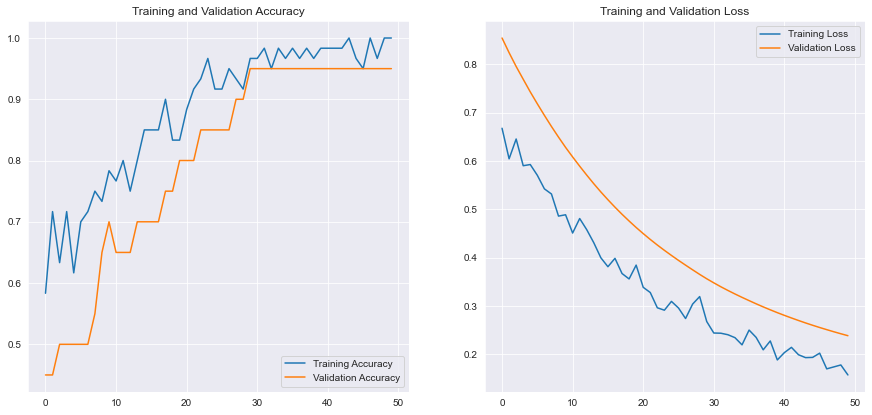

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Here we can see, that the training process shows most likely underfitting. We could now increase the learning rate and/or epochs.

## Inference on transfer learning

This image is 45.4 percent beach and 54.6 percent forest.


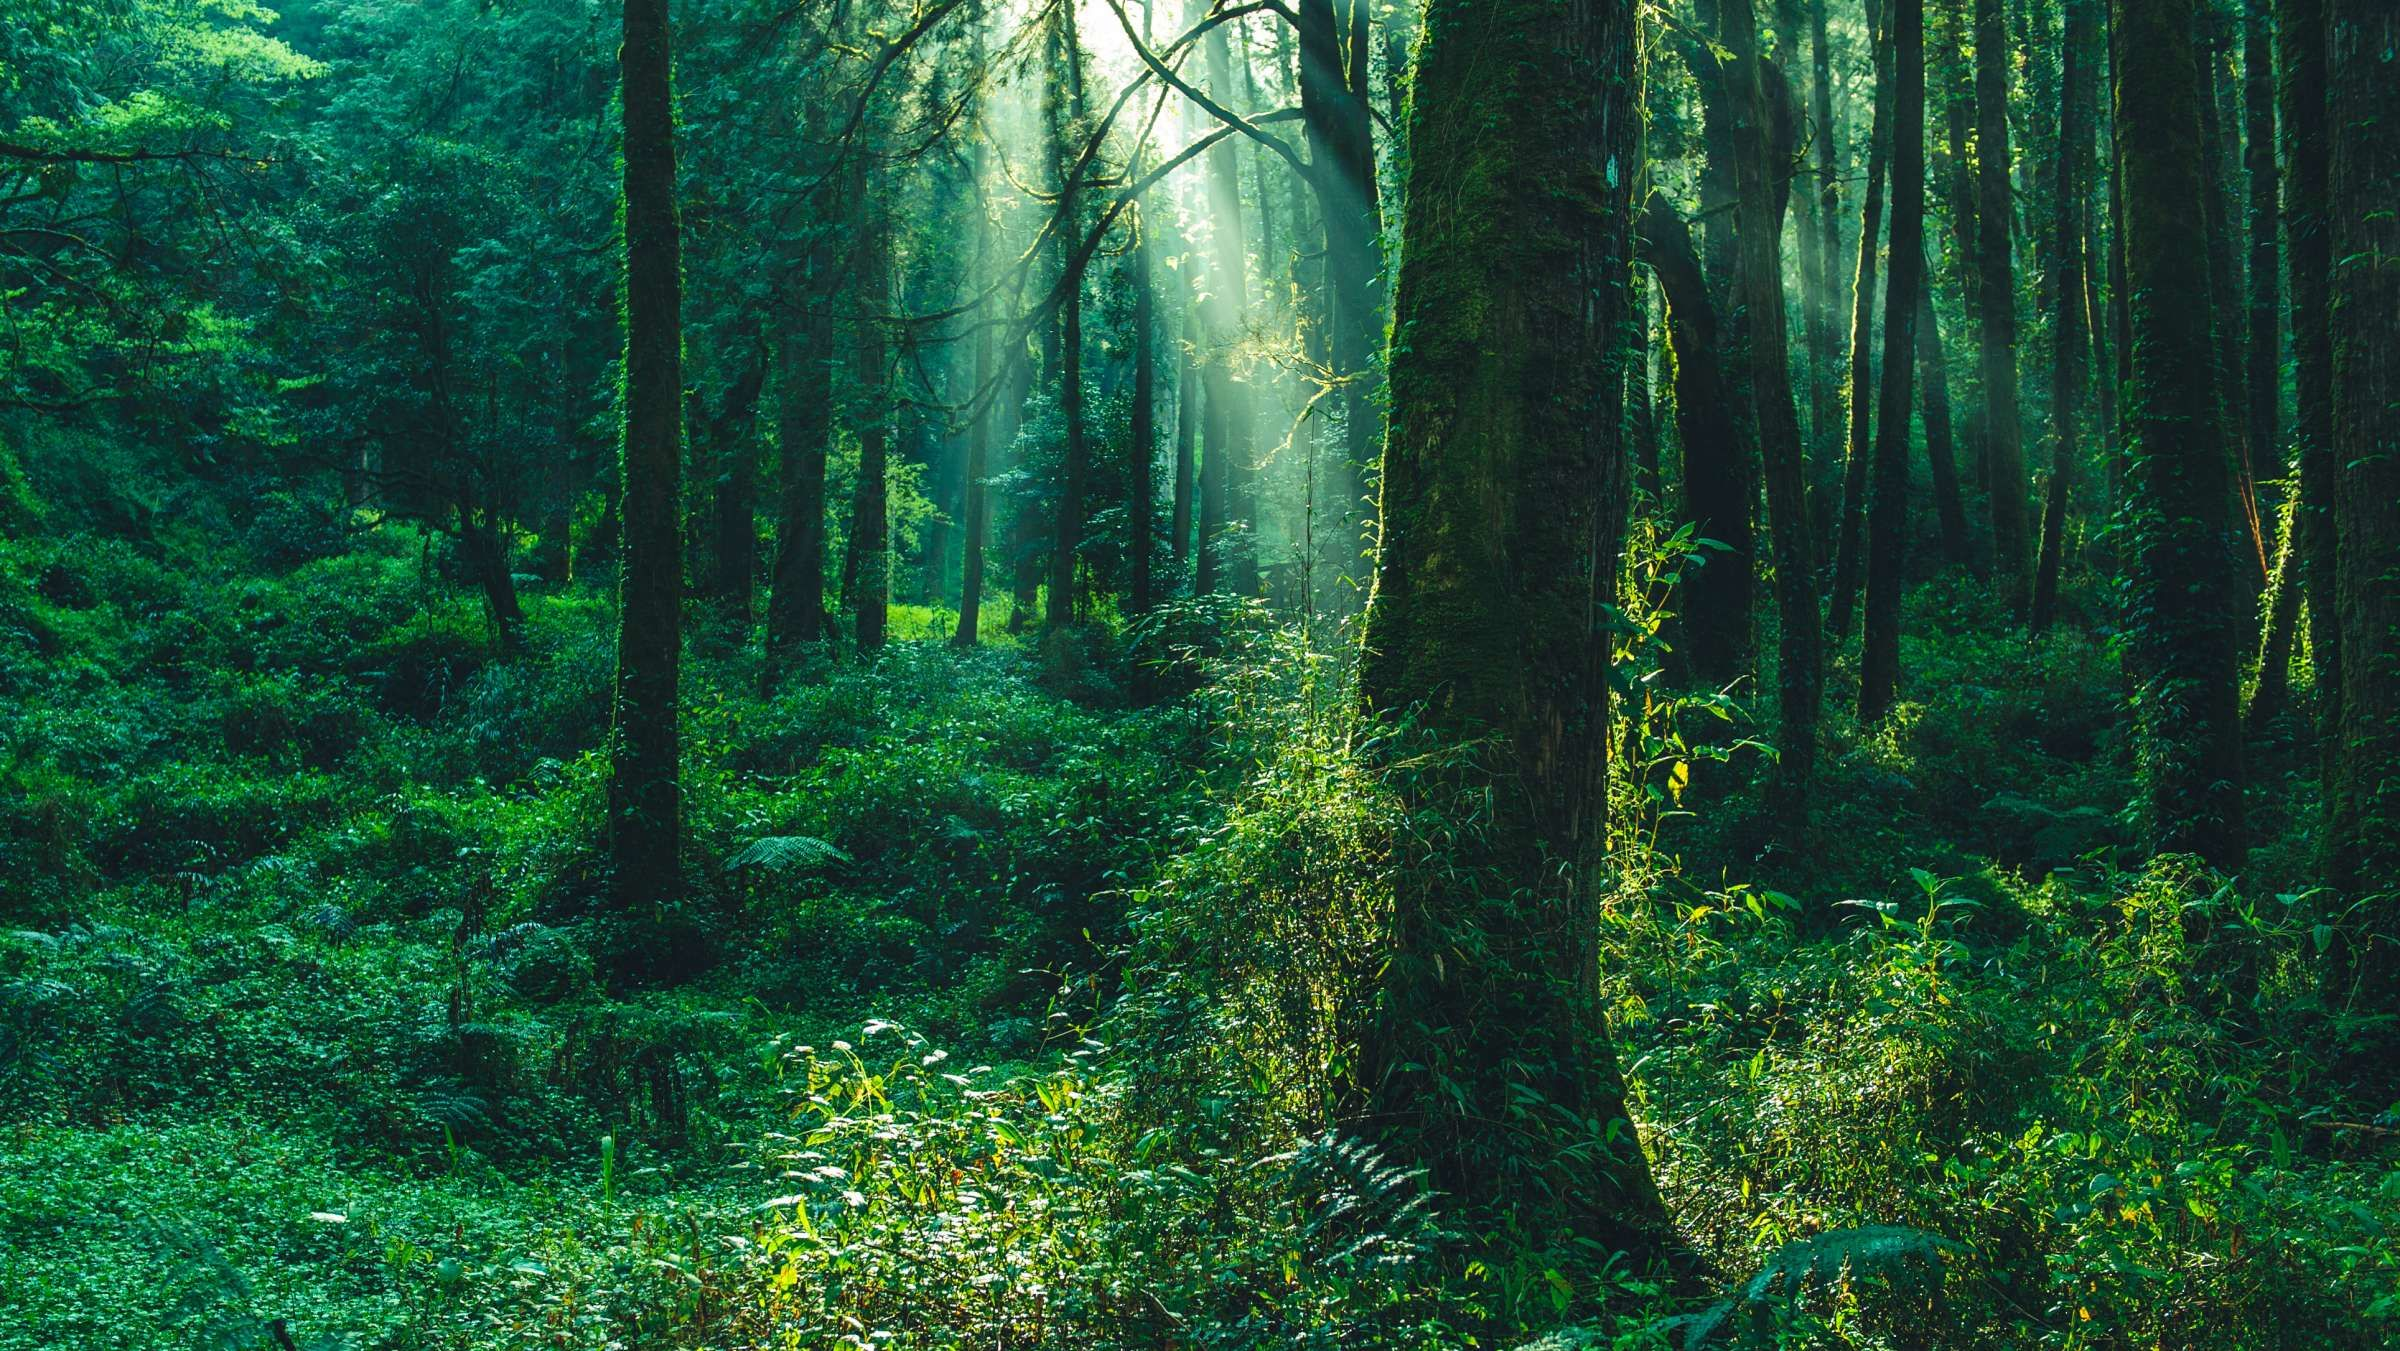

In [100]:
# pick random image from the inference folder
rdm_img = random.choice(inference_files)
image_size = (img_size,img_size)

# predict
img = keras.preprocessing.image.load_img(
    rdm_img, target_size=image_size
    )
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)

# get score
score = predictions[0]
print(
    'This image is %.1f percent %s and %.1f percent %s.'
    %(score[0] * 100, classes[0], score[1] * 100, classes[1]))
Image(filename=rdm_img)

In this example, transfer learning did apparently not make our predictions better.

In [101]:
model_save_path = HOME + 'models/beachforest_50epo_transfer'
model.save(model_save_path)

INFO:tensorflow:Assets written to: ../Data/models/beachforest_50epo_transfer/assets


## References

- https://keras.io/examples/vision/image_classification_from_scratch/
- https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/
